In [1]:
#imports
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import acquire as a
import os
import model as m
from sklearn.model_selection import train_test_split
from scipy import stats
from sklearn.cluster import KMeans


## Cluster Model

In [2]:
df = a.wrangle_wine()
df.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality,type
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,red
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,red
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,red
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,red
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,red


In [3]:
df.shape

(6497, 13)

In [4]:
def get_upper_outliers(s, k):
    '''
    Given a series and a cutoff value, k, returns the upper outliers for the
    series.

    The values returned will be either 0 (if the point is not an outlier), or a
    number that indicates how far away from the upper bound the observation is.
    '''
    q1, q3 = s.quantile([.25, .75])
    iqr = q3 - q1
    upper_bound = q3 + k * iqr
    return s.apply(lambda x: max([x - upper_bound, 0]))


In [5]:
df[(get_upper_outliers(df.alcohol, 1.5) > 0)]

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality,type
652,15.9,0.36,0.65,7.5,0.096,22.0,71.0,0.99760,2.98,0.84,14.90,5,red
5517,6.4,0.35,0.28,1.6,0.037,31.0,113.0,0.98779,3.12,0.40,14.20,7,white
6102,5.8,0.61,0.01,8.4,0.041,31.0,104.0,0.99090,3.26,0.72,14.05,7,white


In [6]:
df = df[~(get_upper_outliers(df.alcohol, 1.5) > 0)]

In [7]:
df = df[~(get_upper_outliers(df.density, 1.5) > 0)]

In [8]:
df.shape

(6491, 13)

In [9]:
train, val, test = a.split_data(df)
train.shape, val.shape, test.shape

((3634, 13), (1558, 13), (1299, 13))

In [10]:
train, val, test = a.dummies(train, val, test)

In [11]:
to_scale = a.get_continuous_feats(df)

train, val, test = a.scale_data(train, val, test, to_scale)
train.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality,type_white
6425,0.186441,0.208,0.174699,0.216110,0.056761,0.197802,0.355062,0.452955,0.589147,0.202312,0.450000,6,1
1124,0.228814,0.400,0.000000,0.062868,0.140234,0.007326,0.019417,0.510253,0.697674,0.231214,0.583333,4,0
4864,0.033898,0.108,0.138554,0.176817,0.048414,0.454212,0.418863,0.589264,0.542636,0.127168,0.000000,3,1
4097,0.254237,0.104,0.216867,0.687623,0.056761,0.219780,0.352288,0.777443,0.426357,0.150289,0.133333,5,1
3737,0.144068,0.128,0.192771,0.318271,0.080134,0.124542,0.266297,0.415561,0.426357,0.052023,0.400000,5,1


In [12]:
kmeans = KMeans(n_clusters=3, n_init='auto')
features = train[['alcohol', 'density']]
kmeans.fit(features)

KMeans(n_clusters=3, n_init='auto')

In [13]:
train['sk_clusters'] = kmeans.labels_

In [14]:
train.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality,type_white,sk_clusters
6425,0.186441,0.208,0.174699,0.216110,0.056761,0.197802,0.355062,0.452955,0.589147,0.202312,0.450000,6,1,1
1124,0.228814,0.400,0.000000,0.062868,0.140234,0.007326,0.019417,0.510253,0.697674,0.231214,0.583333,4,0,1
4864,0.033898,0.108,0.138554,0.176817,0.048414,0.454212,0.418863,0.589264,0.542636,0.127168,0.000000,3,1,0
4097,0.254237,0.104,0.216867,0.687623,0.056761,0.219780,0.352288,0.777443,0.426357,0.150289,0.133333,5,1,0
3737,0.144068,0.128,0.192771,0.318271,0.080134,0.124542,0.266297,0.415561,0.426357,0.052023,0.400000,5,1,1


In [15]:
features = train[['alcohol', 'density', 'sk_clusters']]

In [16]:
train.quality.value_counts()

6    1584
5    1183
7     614
8     119
4     116
3      15
9       3
Name: quality, dtype: int64

In [30]:
bins = [2, 5, 6, 9]

# Define custom labels
labels = ['3-5', '6', '7-9']

# Create a new column "quality_bins" to store the bin labels
train['quality_bins'] = pd.cut(train['quality'], bins=bins, labels=labels)

<function matplotlib.pyplot.show(close=None, block=None)>

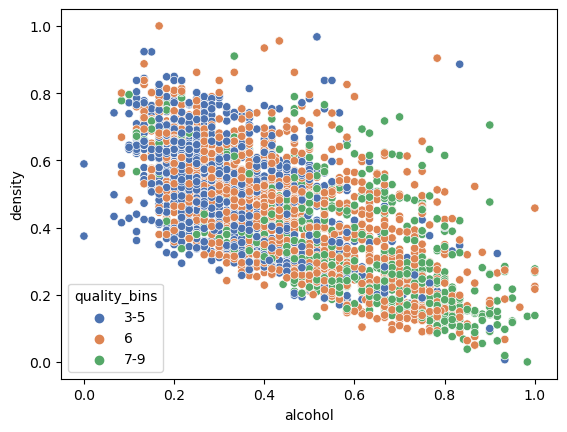

In [31]:
sns.scatterplot(data=train, x='alcohol', y='density', hue='quality_bins', palette='deep')
# plt.ylim(min(train.density), 1.005)
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

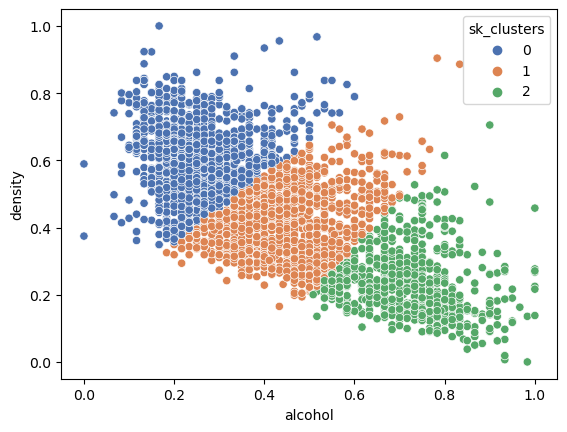

In [32]:
sns.scatterplot(data=train, x='alcohol', y='density', hue='sk_clusters', palette='deep')
#plt.ylim(min(train_scaled.density), .5)
plt.show

## Regression Model

In [33]:
train.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality,type_white,sk_clusters,quality_bins_6,quality_bins_7-9,quality_bins
6425,0.186441,0.208,0.174699,0.216110,0.056761,0.197802,0.355062,0.452955,0.589147,0.202312,0.450000,6,1,1,1,0,6
1124,0.228814,0.400,0.000000,0.062868,0.140234,0.007326,0.019417,0.510253,0.697674,0.231214,0.583333,4,0,1,0,0,3-5
4864,0.033898,0.108,0.138554,0.176817,0.048414,0.454212,0.418863,0.589264,0.542636,0.127168,0.000000,3,1,0,0,0,3-5
4097,0.254237,0.104,0.216867,0.687623,0.056761,0.219780,0.352288,0.777443,0.426357,0.150289,0.133333,5,1,0,0,0,3-5
3737,0.144068,0.128,0.192771,0.318271,0.080134,0.124542,0.266297,0.415561,0.426357,0.052023,0.400000,5,1,1,0,0,3-5


In [21]:
to_scale = a.get_continuous_feats(df)

train, val, test = a.scale_data(train, val, test, to_scale)
train.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality,type_white,sk_clusters,quality_bins
6425,0.186441,0.208,0.174699,0.216110,0.056761,0.197802,0.355062,0.452955,0.589147,0.202312,0.450000,6,1,1,6
1124,0.228814,0.400,0.000000,0.062868,0.140234,0.007326,0.019417,0.510253,0.697674,0.231214,0.583333,4,0,1,3-5
4864,0.033898,0.108,0.138554,0.176817,0.048414,0.454212,0.418863,0.589264,0.542636,0.127168,0.000000,3,1,0,NaN
4097,0.254237,0.104,0.216867,0.687623,0.056761,0.219780,0.352288,0.777443,0.426357,0.150289,0.133333,5,1,0,3-5
3737,0.144068,0.128,0.192771,0.318271,0.080134,0.124542,0.266297,0.415561,0.426357,0.052023,0.400000,5,1,1,3-5


In [22]:
train, val, test = a.dummies(train, val, test)

In [23]:
X_train, y_train = a.xy_split(train)
X_val, y_val = a.xy_split(val)

In [24]:
X_train.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,type_white,sk_clusters,quality_bins_6,quality_bins_7-9
6425,0.186441,0.208,0.174699,0.216110,0.056761,0.197802,0.355062,0.452955,0.589147,0.202312,0.450000,1,1,1,0
1124,0.228814,0.400,0.000000,0.062868,0.140234,0.007326,0.019417,0.510253,0.697674,0.231214,0.583333,0,1,0,0
4864,0.033898,0.108,0.138554,0.176817,0.048414,0.454212,0.418863,0.589264,0.542636,0.127168,0.000000,1,0,0,0
4097,0.254237,0.104,0.216867,0.687623,0.056761,0.219780,0.352288,0.777443,0.426357,0.150289,0.133333,1,0,0,0
3737,0.144068,0.128,0.192771,0.318271,0.080134,0.124542,0.266297,0.415561,0.426357,0.052023,0.400000,1,1,0,0


In [25]:
y_train.mean(), y_train.median()

(5.83516785910842, 6.0)

In [26]:
baselines = pd.DataFrame({'y_actual': y_train,
                         'y_mean': y_train.mean(),
                         'y_median': y_train.median()})

baselines.head()

,y_actual,y_mean,y_median
6425,6,5.835168,6.0
1124,4,5.835168,6.0
4864,3,5.835168,6.0
4097,5,5.835168,6.0
3737,5,5.835168,6.0


In [27]:
m.eval_model(baselines.y_actual, baselines.y_mean)

0.8778233869211627

In [28]:
m.eval_model(baselines.y_actual, baselines.y_median)

0.8931648970356162

In [29]:
lm = LinearRegression()

m.train_model(lm, X_train, y_train, X_val, y_val)

NameError: name 'LinearRegression' is not defined

In [ ]:
X= train[['alcohol', 'density']]

kmeans = KMeans(n_clusters=3)
kmeans.fit(X)

kmeans.predict(X)


In [ ]:
strain['cluster'] = kmeans.predict(X)

In [ ]:
kmeans.cluster_centers_

In [ ]:
centroids = pd.DataFrame(kmeans.cluster_centers_, columns=X.columns)
centroids